# Part 0: Initialising

In [1]:
# Initializing
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf
import requests

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

NUM_COLORS = 15
cm = plt.get_cmap('nipy_spectral')

mpl.rcParams.update(params)

import warnings

warnings.filterwarnings("ignore")

To start with, we import three datasets that are available from YouNiverse:

``df_channels_en.tsv.gz``   
``df_timeseries_en.tsv.gz``   
``yt_metadata_helper.feather``

We will filter the channels that have been identified as Gaming.

In [2]:
df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])

df_channels = df_channels[df_channels['category_cc'] == "Gaming"]
channel_id_gaming = df_channels.channel

In [3]:
df_channels.head()

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
10,Gaming,2015-04-06,UCEdvpU2pFRCVqU6yIPyTpMQ,Marshmello,39100000,366,18.0,2.087
41,Gaming,2012-05-26,UC7_YxT-KID8kRbqZo7MyscQ,Markiplier,24400000,4484,86.0,2.087
42,Gaming,2011-09-15,UCKqH_9mk1waLgBiL2vT5b9g,VanossGaming,24800000,1079,87.0,2.087
52,Gaming,2007-02-24,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,22833014,4255,99.0,2.087


In [4]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])
# round the total number of subscribers, it is easier to consider 1 person and instead half of a person...
df_time_series.subs = df_time_series.subs.round(0)

# we filter the channels being labeled as "Gaming" in df_channels_en.tsv.gz
df_time_series = df_time_series[
    df_time_series['channel'].isin(channel_id_gaming)
]

In [5]:
df_time_series.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
435,UCNNLaOkE-rcthxNssSHET2A,Gaming,2017-05-15,21755.111111,19051.111111,4980.0,0.000000,4,0,4
436,UCNNLaOkE-rcthxNssSHET2A,Gaming,2017-05-22,63875.750000,42120.638889,7588.0,2607.805556,6,2,6
437,UCNNLaOkE-rcthxNssSHET2A,Gaming,2017-05-29,131038.375000,67162.625000,11309.0,3720.875000,9,3,6
438,UCNNLaOkE-rcthxNssSHET2A,Gaming,2017-06-05,216735.000000,85696.625000,19353.0,8043.875000,13,4,8
439,UCNNLaOkE-rcthxNssSHET2A,Gaming,2017-06-12,396499.666667,179764.666667,22547.0,3193.555556,16,3,7


In [6]:
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
        "display_id"
    ],
)

video_metadatas["yearNumber"] = video_metadatas["upload_date"].dt.year
video_metadatas["weekNumber"] = video_metadatas["upload_date"].dt.weekday

# we filter the channels being labeled as "Gaming" in df_channels_en.tsv.gz
video_metadatas = video_metadatas[
    video_metadatas['channel_id'].isin(channel_id_gaming)
]

In [7]:
video_metadatas.head()

,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,display_id,yearNumber,weekNumber
0,Film & Animation,2016-09-28,1159,8.0,1.0,1057.0,UCzWrhkg9eK5I8Bm3HfV-unA,SBqSc91Hn9g,2016,2
1,Film & Animation,2016-09-28,2681,23.0,1.0,12894.0,UCzWrhkg9eK5I8Bm3HfV-unA,UuugEl86ESY,2016,2
2,Film & Animation,2016-09-28,1394,1607.0,779.0,1800602.0,UCzWrhkg9eK5I8Bm3HfV-unA,oB4c-yvnbjs,2016,2
3,Film & Animation,2016-09-28,5064,227.0,24.0,57640.0,UCzWrhkg9eK5I8Bm3HfV-unA,ZaV-gTCMV8E,2016,2
4,Film & Animation,2016-09-28,3554,105.0,13.0,86368.0,UCzWrhkg9eK5I8Bm3HfV-unA,cGvL7AvMfM0,2016,2


In [8]:
len(df_channels)

20143

In [9]:
len(df_time_series.groupby("channel").count())

19698

In [10]:
len(video_metadatas.groupby("channel_id").count())

20143

Since the `df_time_series` only has data from early January 2015 to end September 2019, we will filter out the videos within this time frame for `video_metadatas` for consistency.

In [11]:
video_metadatas = video_metadatas[ (video_metadatas['upload_date'] > df_time_series.datetime.min()) & 
                                   (video_metadatas['upload_date'] < df_time_series.datetime.max()) ]

We will now start filtering out the channels we want, which are those with more than XX % of gaming videos and upload videos every XX days or more. Before the filtering, we have 20143 channels in `video_metadatas` labelled as "Gaming".

In [12]:
# we want to select the channels with more than 60% of gaming videos, therefore, we will filter these channels
video_metadatas['is_gaming'] = (video_metadatas.categories == "Gaming")

count_per_channel = pd.DataFrame(video_metadatas.groupby("channel_id").count().categories).reset_index().rename(columns={"categories":"nr_videos"})
game_video_count_per_channel = pd.DataFrame(video_metadatas.groupby("channel_id").sum().is_gaming).reset_index()

channel_selection = count_per_channel.merge(game_video_count_per_channel)
channel_selection["pct_gaming"] = channel_selection.is_gaming / channel_selection.nr_videos

In [13]:
pct_level = 0.6
selected_channels = list(channel_selection[channel_selection['pct_gaming'] >= pct_level ].channel_id)

In [14]:
len(selected_channels)

18230

After the filtering, we now have 18230 channels. We now want to filter out the channels that upload videos too frequently or too infrequent, as they are not of our interest.

In [15]:
# we also want to filter out channels that upload too frequently, as we are interested in things that could be done by an individual
last_vid_date = pd.DataFrame(video_metadatas.groupby("channel_id").max().
                             upload_date).reset_index().rename(columns={"upload_date":"last_vid_date"})
first_vid_date = pd.DataFrame(video_metadatas.groupby("channel_id").min().
                              upload_date).reset_index().rename(columns={"upload_date":"first_vid_date"})
total_vids = pd.DataFrame(video_metadatas.groupby("channel_id").count().
                          display_id).reset_index().rename(columns={"display_id":"total_vids"})

In [16]:
channel_selection = first_vid_date.merge(last_vid_date)
channel_selection = channel_selection.merge(total_vids)
channel_selection['active_days'] = (channel_selection.last_vid_date - channel_selection.first_vid_date).dt.days
channel_selection['upload_interval'] = channel_selection.active_days / channel_selection.total_vids

In [17]:
min_upload_interval = 2 # in days, the channel upload videos on average every x days 
max_upload_interval = 90
selected_channels = list(channel_selection[(channel_selection['upload_interval'] > min_upload_interval) & 
                                           (channel_selection['upload_interval'] < max_upload_interval) ].channel_id)

In [18]:
len(selected_channels)

14730

Here, we filtered out channels that uploaded videos every 2 days or less. Now we have 14730 channels.

Note that `df_time_series` contains less channels than `df_channels` and `video_metadatas`. In order to keep consistency, we will take the channels that can be found across three dataframes.

In [19]:
df_time_series = df_time_series[df_time_series['channel'].isin(selected_channels)]

In [20]:
selected_channels = list(df_time_series.groupby("channel").count().reset_index().channel)

In [21]:
len(selected_channels)

14380

In [22]:
df_channels = df_channels[df_channels['channel'].isin(selected_channels)]

In [23]:
len(df_channels)

14380

In [24]:
video_metadatas = video_metadatas[video_metadatas['channel_id'].isin(selected_channels)]

In [25]:
len(video_metadatas.groupby("channel_id").count())

14380

We also import a dataset that is created by us, .......  

We will filter the channels that have been identified as Gaming, People & Blogs, or Comedy later on. Note that this does not necessarily mean that all the videos from those channels are in these categories.

In [26]:
titles_metadata = pd.read_feather(
    "./data/yt_metadata_title_helper.feather")

titles_metadata = titles_metadata[
    titles_metadata['display_id'].isin(video_metadatas.display_id)
]

In [27]:
titles_metadata.head()

,categories,display_id,title
1792,Gaming,M0x6TJmMwL4,Blasphemous is Amazing!
1793,Gaming,ofAIp6dad00,I review all 42 Genesis Mini games
1794,Gaming,cXHRNThI27A,Disenchantment Jester Season 2
1795,Gaming,cDSo3mUNEEM,💀 Death Stranding is boring as Hell
1796,Gaming,rJmT1Rq24qE,Happy Friday the 13th. I'm going to try and fi...


In [28]:
tags_metadata = pd.read_feather(
    "./data/yt_metadata_tags_helper.feather")

tags_metadata = tags_metadata[
    tags_metadata['display_id'].isin(video_metadatas.display_id)
]

In [29]:
tags_metadata.head()

,categories,display_id,tags
1792,Gaming,M0x6TJmMwL4,"video,games,retrogamer3,ed,findlay,Blasphemous..."
1793,Gaming,ofAIp6dad00,"video,games,retrogamer3,ed,findlay,Sega,Genesi..."
1794,Gaming,cXHRNThI27A,"video,games,retrogamer3,ed,findlay,Disenchantm..."
1795,Gaming,cDSo3mUNEEM,"video,games,retrogamer3,ed,findlay,Death Stran..."
1796,Gaming,rJmT1Rq24qE,"video,games,retrogamer3,ed,findlay,Friday the ..."


# Part 2: Further Analysis Milestone 3

Given the results in Part 1 of our Analysis, we decided to focus on the categories of Gaming. The reason behind this choice is because we are trying to help our little brother to succeed, and since he is just a single person without a big team behind him it seems more reasonable than e.g. Movies or Film & Entertainment. Therefore, we decided to eliminate Music, How-to & Style, Education, Science & Technology, Entertainment, Film & Entertainment, People & Blogs, Comedy, Movies and Shows. We decided to investigate the three categories mentioned above also because videos uploaded can be addressed to audiences of all three categories.

## Key Questions:
 - Which factors help a YouTuber in Gaming gain more subscribers?
 - How do sentiments in titles and tags affect views and how do these relationships change over time?

### Sub-Question 1 

**Description:** How does the video upload frequency, time of the week, and video length affect the subscription rate of the channels?  
**Method:** Model this using a linear regression model.  
**Timeline:** By 13/12/2022  
**Organization:** Wenxiu  

In [30]:
# we also want to filter out channels that upload too frequently, as we are interested in things that could be done by an individual
avg_upload_weekday = pd.DataFrame(video_metadatas.groupby("channel_id").mean().
                             weekNumber).reset_index().rename(columns={"weekNumber":"avg_upload_weekday"})

avg_video_duration = pd.DataFrame(video_metadatas.groupby("channel_id").mean().
                             duration).reset_index().rename(columns={"duration":"avg_video_duration"})

In [31]:
channel_selection = channel_selection[channel_selection['channel_id'].isin(selected_channels) ]
channel_selection = channel_selection.merge(avg_upload_weekday)
channel_selection = channel_selection.merge(avg_video_duration)
channel_selection = channel_selection.merge(df_channels.loc[:,['channel', 'subscribers_cc']].rename(
    columns={"channel":"channel_id"}))

In [32]:
model_data = channel_selection.loc[:,['upload_interval', 'avg_upload_weekday', 'avg_video_duration', 'subscribers_cc']]

In [33]:
# normalise the data
xmean = np.mean(model_data,axis=0)
xstd = np.std(model_data,axis=0)
Xbzs = (model_data-xmean)/xstd

In [34]:
Xbzs.head(9)

,upload_interval,avg_upload_weekday,avg_video_duration,subscribers_cc
0,-0.447864,-0.698482,5.425201,-0.210988
1,-0.098164,0.932943,-0.485641,-0.211463
2,2.169822,1.192441,-0.457429,-0.176890
3,-0.384435,-0.226633,-0.208489,-0.177439
4,-0.204599,0.551936,-0.463959,-0.136927
5,-0.640058,-0.231730,0.222809,-0.097681
6,-0.476817,1.238126,-0.604184,-0.205291
7,0.165938,2.090297,-0.491045,-0.208773
8,-0.698218,0.220425,0.792583,-0.203824


In [35]:
import statsmodels.formula.api as smf
# Declares the model
mod = smf.ols(formula='subscribers_cc ~ upload_interval + avg_upload_weekday + avg_video_duration', data=Xbzs)

In [36]:
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

In [37]:
# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         subscribers_cc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     13.13
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           1.46e-08
Time:                        17:23:55   Log-Likelihood:                -20385.
No. Observations:               14380   AIC:                         4.078e+04
Df Residuals:                   14376   BIC:                         4.081e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -4.944e-17      0

upload interval and average video duration are statistically significant  
- higher upload interval - lower subcription rate  
- higher average video duration - lower subscription rate

time of upload during the week doesn't matter that much

### Sub-Question 2

**Description:** How does the language used in titles affect subscription number?  
**Method:** We will classify the sentiments of titles and tags using packages such as NLTK and try to see if this factor affects subscription number of the channels using relevant skills we learned in observational studies.  
**Timeline:** By 15/12/2022  
**Organization:** Wenxiu  

In [38]:
#NLP libraries
import spacy, nltk, gensim, sklearn

#Vader
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim.models.phrases import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import pyLDAvis.gensim_models

# Initialise the Spacy analyzer in English
nlp = spacy.load('en_core_web_sm')

In [39]:
def topic_detection(dataset, datatype):
    if (datatype == "title"):
        new_list = []
        # replace all underslash to space
        for x in dataset:
            new_list.append(x.replace("_", " "))
    
    if (datatype == "tag"):
        new_list = []
        for x in dataset:
            step1 = x.replace(" ", "_")
            step2 = step1.replace(",", " ")
            new_list.append(step2)
        
    STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS

    processed_docs = list()
    for doc in nlp.pipe(new_list, n_process=5, batch_size=10):

        # Process document using Spacy NLP pipeline.
        ents = doc.ents  # Named entities

        # Keep only words (no numbers, no punctuation).
        # Lemmatize tokens, to lowercase, remove punctuation and remove stopwords.
        doc = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]

        # Remove common words from a stopword list and keep only words of length 3 or more.
        doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

        # Add named entities, but only if they are a compound of more than word.
        doc.extend([str(entity) for entity in ents if len(entity) > 1])

        processed_docs.append(doc)
    docs = processed_docs
    del processed_docs

    # Add bigrams to docs (only ones that appear 15 times or more).
    bigram = Phrases(docs, min_count=15)

    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)

    # Create a dictionary representation of the documents, and filter out frequent and rare words.
    dictionary = Dictionary(docs)

    # Remove rare and common tokens.
    # Filter out words that occur too frequently or too rarely.
    max_freq = 0.5
    min_wordcount = 5
    dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    seed = 42
    # models
    params = {'passes': 10, 'random_state': seed}
    base_models = dict()
    model = LdaMulticore(corpus=corpus, num_topics=4, id2word=dictionary, workers=6,
                    passes=params['passes'], random_state=params['random_state'])
    return model, corpus, dictionary


In [40]:
# topic detection all videos from titles
model, corpus, dictionary = topic_detection( titles_metadata.title, "title" )
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [41]:
# topic detection for all videos from tags
model, corpus, dictionary = topic_detection( tags_metadata.tags, "tag" )
data =  pyLDAvis.gensim_models.prepare(model, corpus, dictionary)
pyLDAvis.display(data)

In [42]:
positive_sent = []
negative_sent = []
neutral_sent = []
compound_sent = []

#iterate through the sentences, get polarity scores, choose a value
analyzer = SentimentIntensityAnalyzer()
for title in titles_metadata.title:
    score = analyzer.polarity_scores(title)
    positive_sent.append(score['pos'])
    negative_sent.append(score['neg'])
    neutral_sent.append(score['neu'])
    compound_sent.append(score['compound'])

video_metadatas['title_pos_scr'] = positive_sent
video_metadatas['title_neg_scr'] = negative_sent
video_metadatas['title_neu_scr'] = neutral_sent
video_metadatas['title_com_scr'] = compound_sent

Text(0, 0.6, 'Number of videos')

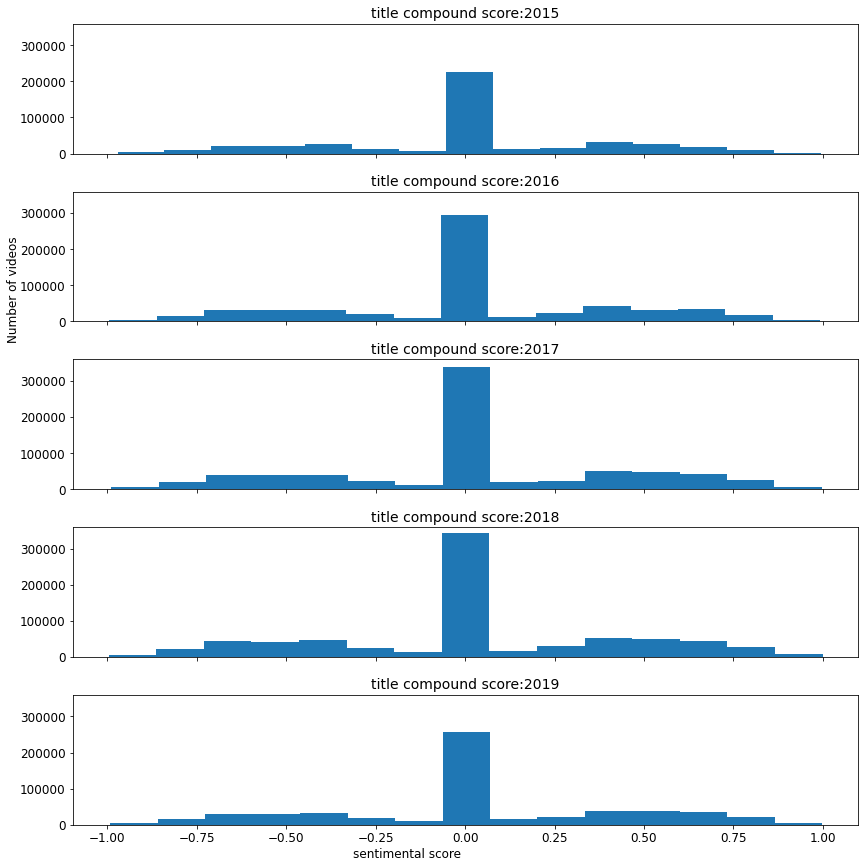

In [43]:
# Write your code to make 4x4 panel here

fig, ax = plt.subplots(5, 1,figsize= (12,12), sharey = True, sharex = True)

year = [2015, 2016, 2017, 2018, 2019]

for i in np.arange(5):
    sbplt = ax[i]
    sbplt.hist(video_metadatas[video_metadatas['yearNumber'] == year[i] ].title_com_scr,bins = 15)
    sbplt.set_title('title compound score:' + str(year[i]) )


fig.tight_layout()

fig.text(0.4,0, "sentimental score")
fig.text(0,0.6, "Number of videos", rotation = 90)

### Sub-Question 3

**Description:** Can we predict the channel's success based on channel information, including average video length, upload frequency, usual time of uploads, categories of videos uploaded, positive/negative sentiments of the title, person pronouns to address the viewers, the number of words in the title, and the number of tags used?  
**Method:** We can implement kNN method or Random Forests to train the dataset.  
**Timeline:** By 13/12/2022  
**Organization:** Dorothee  

### Sub-Question 4
**Description:** What are the most common topics in each of the chosen categories?  
**Method:** The yt_metadata_en.jsonl.gz dataset will be used to get a list of tags of each video according to its category. It is further split and classified according to the topics that occur most frequently. This way, we get the most used keywords in each video category and therefore the most popular topics.  
**Timeline:** By 15/12/2022  
**Organization:** Jules  

### Sub-Question 5
**Description:** Does a channel's success increase with a greater variety of categories?  
**Method:** For this question, we will determine whether the filtered channels use multiple categories in their videos, and if they showed clear shifts from one category to another. Ultimately, we want to use this information and methods such as A/B testing and observational studies to determine whether a greater variety of categories can aid to a channels’ success.  
**Timeline:** By 18/12/2022  
**Organization:** Paul  